In [48]:
# load packages 
library(pacman)
p_load(
    tidyverse, data.table, dtplyr, reshape2, 
    archive, kableExtra, SPARQL, janitor, 
    png, webp, Cairo, rsvg,
    httr, jsonlite)
# set option
options(dplyr.summarise.inform = FALSE)
gray_scale <- c('#F3F4F8','#D2D4DA',  '#bcc0ca', 
                '#D3D3D3', '#2B2B2B', 
                '#B3B5BD', '#838383', 
                '#9496A1', '#7d7f89', '#777986', 
                '#656673', '#5B5D6B', '#4d505e',
                '#404352', '#2b2d3b', '#282A3A',
                '#1b1c2a', '#191a2b',
                '#141626', '#101223')

In [2]:
han_names <- fread('work/notebooks/patent/data/202208_HAN_NAMES.txt')

In [3]:
dim(han_names)

[1] 4191007       3

In [7]:
head(han_names)

HAN_ID,Clean_name,Person_ctry_code
<int>,<chr>,<chr>
1,& HAMBOURG NIENDORF,DE
2,& KK,JP
3,“ASTRONIT” CLOSE CORP,RU
4,“DEUTSCHE SEE” GMBH,DE
5,“EFIRNOIE” OPEN JOINT STOCK CO,RU
6,“EUROSTANDART” LTD LIABILITY CO,RU


In [4]:
de_firms <- fread('work/notebooks/patent/data/orbis_de_matched_l.csv')

In [55]:
han_names %>%
    .[1:5,] %>%
    kable('pipe', align='ccc')



| HAN_ID |           Clean_name           | Person_ctry_code |
|:------:|:------------------------------:|:----------------:|
|   1    |      & HAMBOURG NIENDORF       |        DE        |
|   2    |              & KK              |        JP        |
|   3    |     “ASTRONIT” CLOSE CORP      |        RU        |
|   4    |      “DEUTSCHE SEE” GMBH       |        DE        |
|   5    | “EFIRNOIE” OPEN JOINT STOCK CO |        RU        |

In [53]:
de_firms %>%
    .[1:5, 2:3]

name_native,name_internat
<chr>,<chr>
Airbus Defence and Space GmbH,Airbus Defence and Space GmbH
EurA AG,EurA AG
TuTech Innovation GmbH,TuTech Innovation GmbH
FFT Produktionssysteme GmbH & Co. KG.,FFT Produktionssysteme GmbH & Co. KG.
Diehl Aviation Laupheim GmbH,Diehl Aviation Laupheim GmbH


In [5]:
# query
airbus <- toupper('Airbus Defence')
han_names %>%
    .[Person_ctry_code == 'DE'] %>%
    .[Clean_name %like% airbus] %>%
    .[,HAN_ID] -> airbus_han_ids
airbus_han_ids

[1]   60513   62422 3637004 4401227 4527012

In [7]:
han_patents <- fread('work/notebooks/patent/data/202208_HAN_PATENTS.txt')

In [8]:
han_patents %>%
    .[HAN_ID %in% airbus_han_ids] %>%
    .[, .N, by=Publn_auth] -> foo
    transform(adorn_totals(foo)) %>%
    transpose() %>%
    row_to_names(row_number=1)

,EP,US,WO,Total
,<chr>,<chr>,<chr>,<chr>
2,716,415,88,1219


In [84]:
han_patents %>%
    .[HAN_ID %in% airbus_han_ids] %>%
    .[sample(.N, 5)]

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number
<int>,<int>,<int>,<chr>,<chr>
60513,60513,442096647,EP,EP3112597
60513,60513,417401751,EP,EP2913271
60513,60513,404985890,EP,EP2825450
60513,60513,527283926,US,US2020070202
60513,60513,544408405,WO,WO2021123759


In [51]:
han_patents %>%
    .[HAN_ID %in% airbus_han_ids] %>%
    .[Publn_auth == 'EP'] -> airbus_ep_patents
    head(airbus_ep_patents)

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number
<int>,<int>,<int>,<chr>,<chr>
60513,60513,213,EP,EP2030891
60513,60513,65448,EP,EP2025928
60513,60513,156990,EP,EP1920908
60513,60513,161551,EP,EP1972896
60513,60513,173385,EP,EP2134522
60513,60513,173386,EP,EP2136979


In [27]:
request <- GET('https://data.epo.org/linked-data/data/publication/EP/1972896.json')

In [28]:
response <- content(request, as = "text", encoding = "UTF-8")
json <- fromJSON(response, flatten = TRUE)
names(json$result)

In [12]:
head(json$result$items)

,_about,label,publicationAuthority,publicationDate,application._about,application.applicationNumber,publicationKind._about,publicationKind.label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,http://data.epo.org/linked-data/data/publication/EP/1972896/A2/-,EP 1972896 A2,http://data.epo.org/linked-data/id/st3/EP,"Wed, 24 Sep 2008",http://data.epo.org/linked-data/id/application/EP/08004318,08004318,http://data.epo.org/linked-data/def/patent/publicationKind_A2,A2
2,http://data.epo.org/linked-data/data/publication/EP/1972896/A3/-,EP 1972896 A3,http://data.epo.org/linked-data/id/st3/EP,"Wed, 07 Nov 2012",http://data.epo.org/linked-data/id/application/EP/08004318,08004318,http://data.epo.org/linked-data/def/patent/publicationKind_A3,A3
3,http://data.epo.org/linked-data/data/publication/EP/1972896/B1/-,EP 1972896 B1,http://data.epo.org/linked-data/id/st3/EP,"Wed, 06 May 2015",http://data.epo.org/linked-data/id/application/EP/08004318,08004318,http://data.epo.org/linked-data/def/patent/publicationKind_B1,B1


In [15]:
json$result$items %>%
    select(
        `_about`, 
        publicationDate, 
        application.applicationNumber,
        publicationKind.label) %>%
    rename(Link=`_about`, Publication_date=publicationDate, 
        Application_number=application.applicationNumber, 
        Kind_code=publicationKind.label) %>%
        kable('pipe', align='lccc')



|Link                                                             | Publication_date | Application_number | Kind_code |
|:----------------------------------------------------------------|:----------------:|:------------------:|:---------:|
|http://data.epo.org/linked-data/data/publication/EP/1972896/A2/- | Wed, 24 Sep 2008 |      08004318      |    A2     |
|http://data.epo.org/linked-data/data/publication/EP/1972896/A3/- | Wed, 07 Nov 2012 |      08004318      |    A3     |
|http://data.epo.org/linked-data/data/publication/EP/1972896/B1/- | Wed, 06 May 2015 |      08004318      |    B1     |

In [81]:
get_publications <- function(url) {
    # initialize df
    df0 <- data.frame(
            link=character(),
            pub_date=character(),
            appln_number=character(),
            kind_code=character(),
            stringsAsFactors = FALSE
        )
    # set up headers 
    request <- GET(
        url,
        add_headers(
            Host = "data.epo.org",
            `User-Agent` = "Chrome/88.0.4324.188"
        )
    )

    print(status_code(request))
    if (status_code(request) == 200) {
        response <- content(request, as = "text", encoding = "UTF-8")
        json <- fromJSON(response, flatten = TRUE)

        if (length(json$result$items) == 0){
            return(df0)
        } else {
            json$result$items %>%
            select(
                publicationDate, 
                application.applicationNumber,
                publicationKind.label) %>%
            rename(pub_date=publicationDate, 
                appln_number=application.applicationNumber, 
                kind_code=publicationKind.label) -> df

                return(df)
        }
    } else {
        return(df0)
    }

    return(df0)
}

In [53]:
get_granted <- function(url, kind='B1') {
    df <- get_publications(url)
    df %>%
        filter(kind_code == kind) -> foo
    
    return(foo)
}

In [54]:
construct_url <- function(patent_number) {
    pub_link = 'https://data.epo.org/linked-data/data/publication/EP/'
    patent_number <- gsub('EP', '', patent_number)
    pn <- str_trim(patent_number)
    link <- paste(pub_link, pn, '.json', sep="")

    return(link)
}

In [57]:
url = construct_url('EP2136979')

In [71]:
get_granted(url)

[1] 200


pub_date,appln_number,kind_code
<chr>,<chr>,<chr>
"Wed, 14 Oct 2015",05715021,B1


In [142]:
head(airbus_ep_patents)

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number
<int>,<int>,<int>,<chr>,<chr>
60513,60513,213,EP,EP2030891
60513,60513,65448,EP,EP2025928
60513,60513,156990,EP,EP1920908
60513,60513,161551,EP,EP1972896
60513,60513,173385,EP,EP2134522
60513,60513,173386,EP,EP2136979


In [157]:
dim(airbus_ep_patents)[1]

[1] 716

In [61]:
head(airbus_ep_patents)

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number
<int>,<int>,<int>,<chr>,<chr>
60513,60513,213,EP,EP2030891
60513,60513,65448,EP,EP2025928
60513,60513,156990,EP,EP1920908
60513,60513,161551,EP,EP1972896
60513,60513,173385,EP,EP2134522
60513,60513,173386,EP,EP2136979


In [72]:
foo <- data.frame(
    granted = integer(),
    pub_date = character(),
    appln_number = character(),
    kind_code = character()
)
airbus_granted <- cbind(airbus_ep_patents, foo)
tail(airbus_granted)

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code
<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
60513,60513,543179431,EP,EP3840175,NA,NA,NA,NA
60513,60513,544285732,EP,EP3851783,NA,NA,NA,NA
60513,60513,544873605,EP,EP3860302,NA,NA,NA,NA
60513,60513,545964455,EP,EP3871980,NA,NA,NA,NA
60513,60513,547077828,EP,EP3882371,NA,NA,NA,NA
60513,60513,549789029,EP,EP3907656,NA,NA,NA,NA


In [82]:
for (i in 1:nrow(airbus_granted)){
    print(paste('request-----------:', i))
    flush.console()
    Sys.sleep(0.5)
    pn <- airbus_granted[i, Patent_number]
    url <- construct_url(pn)
    gdf <- get_granted(url)
    if (dim(gdf)[1] == 0) {
        airbus_granted[i, 'granted'] <- 0
    } else {
        airbus_granted[i, 'granted'] <- 1
        airbus_granted[i, 'pub_date'] <- gdf[1, 'pub_date']
        airbus_granted[i, 'appln_number'] <- gdf[1, 'appln_number']
        airbus_granted[i, 'kind_code'] <- gdf[1, 'kind_code']
    }
}

[1] "request-----------: 1"
[1] 200
[1] "request-----------: 2"
[1] 200
[1] "request-----------: 3"
[1] 200
[1] "request-----------: 4"
[1] 200
[1] "request-----------: 5"
[1] 200
[1] "request-----------: 6"
[1] 200
[1] "request-----------: 7"
[1] 200
[1] "request-----------: 8"
[1] 200
[1] "request-----------: 9"
[1] 200
[1] "request-----------: 10"
[1] 200
[1] "request-----------: 11"
[1] 200
[1] "request-----------: 12"
[1] 200
[1] "request-----------: 13"
[1] 200
[1] "request-----------: 14"
[1] 200
[1] "request-----------: 15"
[1] 200
[1] "request-----------: 16"
[1] 200
[1] "request-----------: 17"
[1] 200
[1] "request-----------: 18"
[1] 200
[1] "request-----------: 19"
[1] 200
[1] "request-----------: 20"
[1] 200
[1] "request-----------: 21"
[1] 200
[1] "request-----------: 22"
[1] 200
[1] "request-----------: 23"
[1] 200
[1] "request-----------: 24"
[1] 200
[1] "request-----------: 25"
[1] 200
[1] "request-----------: 26"
[1] 200
[1] "request-----------: 27"
[1] 200
[1] "reque

In [83]:
head(airbus_granted)

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code
<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
60513,60513,213,EP,EP2030891,0,NA,NA,NA
60513,60513,65448,EP,EP2025928,0,NA,NA,NA
60513,60513,156990,EP,EP1920908,1,"Wed, 08 Apr 2015",07021377,B1
60513,60513,161551,EP,EP1972896,1,"Wed, 06 May 2015",08004318,B1
60513,60513,173385,EP,EP2134522,1,"Wed, 01 Mar 2017",08717791,B1
60513,60513,173386,EP,EP2136979,1,"Wed, 11 May 2016",08717792,B1


In [96]:
tail(airbus_granted)

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code
<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
60513,60513,543179431,EP,EP3840175,0,NA,NA,NA
60513,60513,544285732,EP,EP3851783,0,NA,NA,NA
60513,60513,544873605,EP,EP3860302,0,NA,NA,NA
60513,60513,545964455,EP,EP3871980,0,NA,NA,NA
60513,60513,547077828,EP,EP3882371,0,NA,NA,NA
60513,60513,549789029,EP,EP3907656,0,NA,NA,NA


In [97]:
write.csv(airbus_granted, file="work/notebooks/patent/data/airbus_granted.csv")

In [111]:
airbus_granted %>%
    .[, .N, by=granted] -> foo
    transform(adorn_totals(foo)) %>%
    .[, `:=`(share = N/716*100)] %>%
    kable('pipe', align='ccc', digits=2)



| granted |  N  | share  |
|:-------:|:---:|:------:|
|    0    | 178 | 24.86  |
|    1    | 538 | 75.14  |
|  Total  | 716 | 100.00 |

In [148]:
airbus_granted %>%
    .[granted == 1] %>%
    .[, c('date') := tstrsplit(pub_date, ",", keep=2)] %>%
    .[, c('year') := tstrsplit(date, " ", keep=4)] %>%
    .[, date := as.Date(date, "%d %b %Y")] -> airbus_granted_date
    

In [149]:
head(airbus_granted_date)

HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code,date,year
<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<date>,<chr>
60513,60513,156990,EP,EP1920908,1,"Wed, 08 Apr 2015",07021377,B1,2015-04-08,2015
60513,60513,161551,EP,EP1972896,1,"Wed, 06 May 2015",08004318,B1,2015-05-06,2015
60513,60513,173385,EP,EP2134522,1,"Wed, 01 Mar 2017",08717791,B1,2017-03-01,2017
60513,60513,173386,EP,EP2136979,1,"Wed, 11 May 2016",08717792,B1,2016-05-11,2016
60513,60513,188882,EP,EP1976108,1,"Wed, 21 Oct 2020",08004255,B1,2020-10-21,2020
60513,60513,357750,EP,EP2039604,1,"Wed, 01 Mar 2017",08016066,B1,2017-03-01,2017


In [153]:
airbus_granted_date %>%
    .[, .N, by=year]

year,N
<chr>,<int>
2015,22
2017,69
2016,54
2020,87
2018,91
2019,114
2021,48
2014,6
2022,43


In [20]:
foo <- read_csv('work/notebooks/patent/temp.csv')
foo

Rows: 8 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ipc_top
dbl (1): frequency

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ipc_top,frequency
<chr>,<dbl>
B,745
H,356
G,340
C,152
F,115
A,31
D,15
E,9


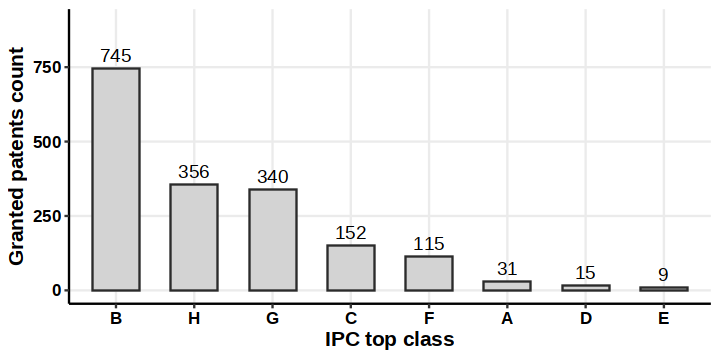

In [46]:
options(repr.plot.width = 6, repr.plot.height = 3)
foo %>%
    ggplot(aes(x=reorder(ipc_top, -frequency), y=frequency)) + 
    geom_col(fill=gray_scale[4], color=gray_scale[5], width=0.6) +
    theme_bw() + 
    ylim(0, 900) +
    geom_text(aes(label=frequency), vjust=-0.5) + 
    labs(
        x='IPC top class', 
        y='Granted patents count',
    ) +
    theme(
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.line = element_line(color = "black"),
        axis.text.x=element_text(face='bold', color='black', size=10),
        axis.title.x=element_text(size=12, face='bold'),
        axis.text.y=element_text(face='bold', color='black', size=10),
        axis.title.y=element_text(size=12, face='bold'),
        ) -> p1

p1
    

In [47]:
ggsave(
    p1, 
    file='work/docs/images/blog/airbus_ipc_top.png',
    width=6, height=3, type="cairo-png",
    device = grDevices::png, 
    dpi=300, bg='transparent')

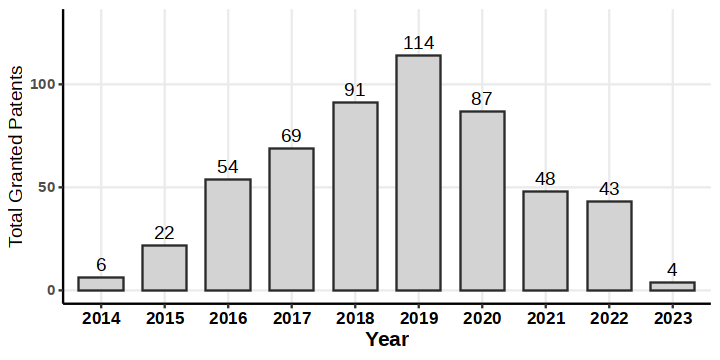

In [319]:
options(repr.plot.width = 6, repr.plot.height = 3)
airbus_granted_date %>%
    group_by(year) %>%
    summarize(N = n()) %>%
    as_tibble() %>%
    ggplot(aes(x=year, y=N)) +
    geom_col(
        fill=gray_scale[4], color=gray_scale[5], 
        size=0.5, width=0.7) +
    geom_text(aes(label=N), vjust=-0.5) + 
    theme_bw() +
    ylim(0, 130) +
    labs(
        x='Year', 
        y='Total Granted Patents',
    ) +
    theme(
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.line = element_line(color = "black"),
        axis.text.x=element_text(face='bold', color='black', size=10),
        axis.title.x=element_text(size=12, face='bold'),
        axis.text.y=element_text(face='bold'),
        ) -> p1

p1

In [320]:
ggsave(
    p1, 
    file='work/docs/images/blog/airbus_patent.png',
    width=6, height=3, type="cairo-png",
    device = grDevices::png, 
    dpi=300, bg='transparent')

In [321]:
write_webp(readPNG('work/docs/images/blog/airbus_patent.png'), 'work/docs/images/blog/airbus_patent.webp')

In [2]:
# read the dataset
airbus <- fread('work/notebooks/patent/data/airbus_granted.csv')

In [3]:
head(airbus)

V1,HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code
<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,60513,60513,213,EP,EP2030891,0,NA,NA,NA
2,60513,60513,65448,EP,EP2025928,0,NA,NA,NA
3,60513,60513,156990,EP,EP1920908,1,"Wed, 08 Apr 2015",7021377,B1
4,60513,60513,161551,EP,EP1972896,1,"Wed, 06 May 2015",8004318,B1
5,60513,60513,173385,EP,EP2134522,1,"Wed, 01 Mar 2017",8717791,B1
6,60513,60513,173386,EP,EP2136979,1,"Wed, 11 May 2016",8717792,B1


In [4]:
airbus %>%
    .[granted==1,] -> airbus_granted
head(airbus_granted)

V1,HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code
<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
3,60513,60513,156990,EP,EP1920908,1,"Wed, 08 Apr 2015",7021377,B1
4,60513,60513,161551,EP,EP1972896,1,"Wed, 06 May 2015",8004318,B1
5,60513,60513,173385,EP,EP2134522,1,"Wed, 01 Mar 2017",8717791,B1
6,60513,60513,173386,EP,EP2136979,1,"Wed, 11 May 2016",8717792,B1
7,60513,60513,188882,EP,EP1976108,1,"Wed, 21 Oct 2020",8004255,B1
8,60513,60513,357750,EP,EP2039604,1,"Wed, 01 Mar 2017",8016066,B1


In [13]:
tail(airbus_granted)

V1,HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code
<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
696,60513,60513,527943540,EP,EP3883144,1,"Wed, 07 Dec 2022",20163878,B1
697,60513,60513,527977383,EP,EP3882376,1,"Wed, 05 Oct 2022",20164194,B1
698,60513,60513,528224000,EP,EP3886189,1,"Wed, 06 Jul 2022",20165725,B1
700,60513,60513,529690180,EP,EP3731055,1,"Wed, 08 Sep 2021",20170301,B1
701,60513,60513,530051711,EP,EP3905535,1,"Wed, 27 Apr 2022",20171723,B1
706,60513,60513,531407299,EP,EP3913398,1,"Wed, 16 Nov 2022",20175733,B1


In [5]:
# classification 

construct_url <- function(patent_number) {
    pub_link = 'https://data.epo.org/linked-data/data/publication/EP/'
    patent_number <- gsub('EP', '', patent_number)
    pn <- str_trim(patent_number)
    link <- paste(pub_link, pn, '/B1/-', sep="")

    return(link)
}

In [36]:
get_ipc <- function(url){
    # set up headers 
    request <- GET(
        url,
        add_headers(
            Host = "data.epo.org",
            `User-Agent` = "Chrome/88.0.4324.188"
        )
    )

    print(status_code(request))

    # initialize a vector
    ipc_c <- c()
    if (status_code(request) == 200) {
        response <- content(request, as = "text", encoding = "UTF-8")
        json <- fromJSON(response, flatten = TRUE)
        ipcs <- json$result$primaryTopic$classificationIPCInventive

        if (is.atomic(ipcs)){
            ipcs_split <- strsplit(ipcs, split="/")
            ipc_c <- append(ipc_c, tail(ipcs_split[[1]], 1))
            print(url)
            print(ipc_c)
        } else {
            ipc_c <- append(ipc_c, ipcs$label)
        }
        

    }

    return(ipc_c)
}

In [93]:
url <- construct_url('EP3731055')
url

[1] "https://data.epo.org/linked-data/data/publication/EP/3731055/B1/-"

In [97]:
ex1 <- get_ipc(url)
ex1

[1] 200


[1] "G05D 1/06"

In [7]:
airbus_granted %>%
    .[sample(.N, 5)] %>%
    .[, .(Patent_number)] -> foo

In [8]:
foo

Patent_number
<chr>
EP2930395
EP3173218
EP2837556
EP2913269
EP3501969


In [9]:
get_ipc2 <- function(pn){
    url <- construct_url(pn)
    ipcs <- get_ipc(url)

    return(ipcs)
}

In [10]:
foo %>%
    .[, ipc := lapply(Patent_number, get_ipc2)] -> hello


[1] 200
[1] 200
[1] 200
[1] 200
[1] 200


In [12]:
hello

Patent_number,ipc
<chr>,<list>
EP2930395,"B64C 27/00, F16F 15/00"
EP3173218,B29C 70/38
EP2837556,"B64C 13/12, F16D 11/04"
EP2913269,B64C 27/82
EP3501969,"B29C 70/24, B32B 7/08 , B64C 1/00 , B64C 1/12"


In [37]:
airbus_granted %>%
    .[, ipc := lapply(Patent_number, get_ipc2)] -> airbus_granted_ipc


[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] "https://data.epo.org/linked-data/data/publication/EP/2748761/B1/-"
[1] "G06K9-00"
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[1] 200
[

In [41]:
head(airbus_granted_ipc)

V1,HAN_ID,HARM_ID,Appln_id,Publn_auth,Patent_number,granted,pub_date,appln_number,kind_code,ipc
<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<list>
3,60513,60513,156990,EP,EP1920908,1,"Wed, 08 Apr 2015",7021377,B1,"B29C 70/38, B29C 70/54, B29C 70/56"
4,60513,60513,161551,EP,EP1972896,1,"Wed, 06 May 2015",8004318,B1,"B64D 45/08, G01C 23/00"
5,60513,60513,173385,EP,EP2134522,1,"Wed, 01 Mar 2017",8717791,B1,"B29B 11/16 , B29C 70/20 , B29C 70/38 , B29C 70/54 , B65H 49/18 , B65H 51/005, B65H 57/16 , D02J 1/18 , D04H 1/4242, D04H 1/60 , D04H 1/655 , D04H 13/00 , D04H 3/002 , D04H 3/04 , D04H 3/12"
6,60513,60513,173386,EP,EP2136979,1,"Wed, 11 May 2016",8717792,B1,"B29B 11/16, B29C 70/38, B29C 70/54"
7,60513,60513,188882,EP,EP1976108,1,"Wed, 21 Oct 2020",8004255,B1,"H02M 3/337 , H02M 7/5387"
8,60513,60513,357750,EP,EP2039604,1,"Wed, 01 Mar 2017",8016066,B1,"B64D 1/04, F41A 9/09, G01B 7/00, G01B 7/14, G01S 5/16"


In [62]:
length(as.factor(unlist(airbus_granted_ipc$ipc)))

[1] 1675

In [59]:
airbus_granted_ipc$ipc[1] -> foo
unlist(foo) -> foo2
as.factor(foo2)

[1] B29C 70/38 B29C 70/54 B29C 70/56
Levels: B29C 70/38 B29C 70/54 B29C 70/56

In [40]:
write.csv(
    as.data.frame(airbus_granted_ipc), 
    file='work/notebooks/patent/data/airbus_granted_ipc.csv',
    row.names=FALSE)

ERROR: Error in utils::write.table(as.data.frame(airbus_granted_ipc), file = "work/notebooks/patent/data/airbus_granted_ipc.csv", : unimplemented type 'list' in 'EncodeElement'

